In [ ]:
!pip install pandas numpy opencv-python tensorflow moviepy scikit-learn matplotlib seaborn spacy


In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install tensorflow.keras

Upload your creative files (images/videos):


Saving video.mp4 to video (3).mp4
Saving sample3.jpg to sample3 (3).jpg
Saving sample2.jpg to sample2 (3).jpg
Saving sample1.jpg to sample1 (5).jpg
Upload your performance CSV file:


Saving performance.csv to performance (5).csv
Creative ID: video, File Path: creatives/video (3).mp4
Creative ID: sample3, File Path: creatives/sample3 (3).jpg
Creative ID: sample2, File Path: creatives/sample2 (3).jpg
Creative ID: sample1, File Path: creatives/sample1 (5).jpg
DataFrame after join:
          click_through_rate  conversion_rate  impressions  \
sample1                0.06            0.020        12000   
sample2                0.08            0.030        15000   
sample3                0.04            0.010         8000   
video                  0.07            0.025        18000   

                         file_path  
sample1  creatives/sample1 (5).jpg  
sample2  creatives/sample2 (3).jpg  
sample3  creatives/sample3 (3).jpg  
video      creatives/video (3).mp4  
Analyzing image from file: creatives/sample1 (5).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Analyzing image from file: creatives/sample2 (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Analyzing image from file: 

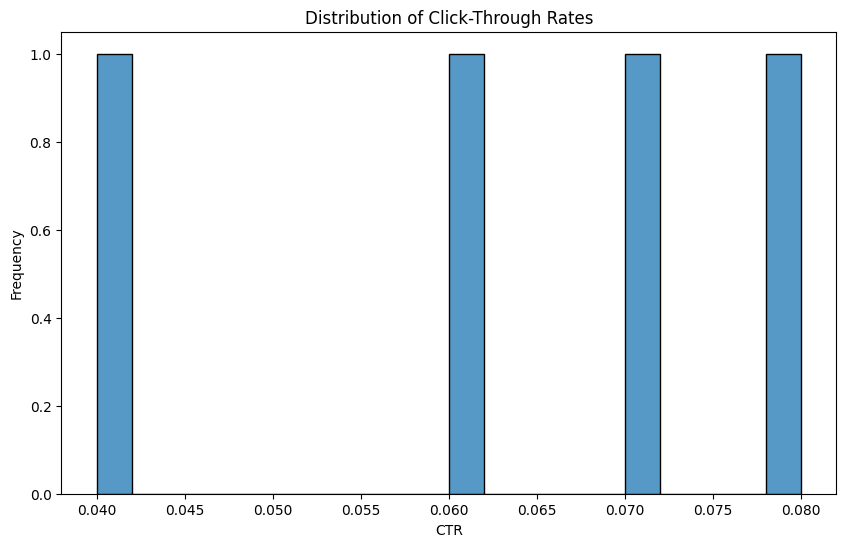

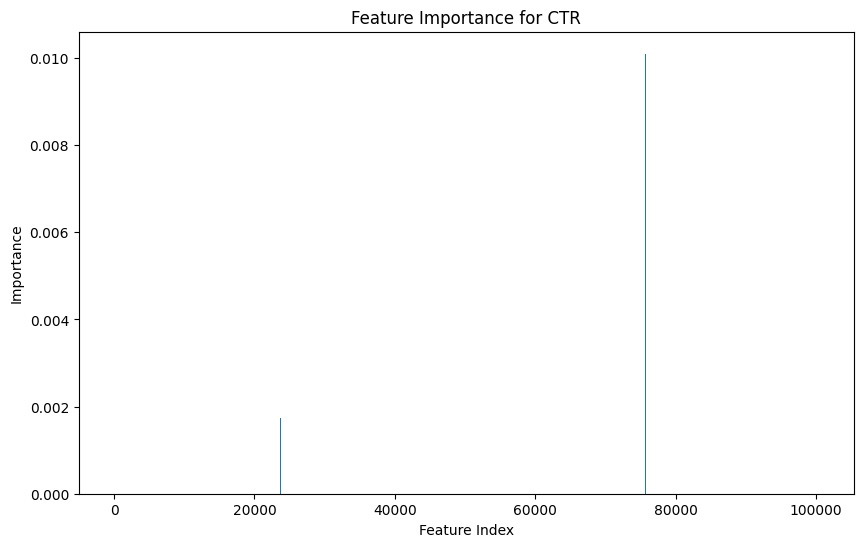

Analysis complete. Graphs displayed above.


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import cv2
from google.colab import files
import os
from pathlib import Path
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from io import BytesIO
import re

# Set up inline plotting
%matplotlib inline

# Initialize models
resnet_model = ResNet50(weights='imagenet', include_top=False)
nlp = spacy.load('en_core_web_sm')

# Data Ingestion
def ingest_data(creative_files, performance_file):
    """Load uploaded creatives and performance data into a dataframe."""
    os.makedirs('creatives', exist_ok=True)
    creatives = {}
    for filename, content in creative_files.items():
        file_path = os.path.join('creatives', filename)
        with open(file_path, 'wb') as f:
            f.write(content)
        # Clean the creative_id by removing Colab's suffix like " (1)"
        creative_id = re.sub(r'\s\(\d+\)', '', Path(filename).stem)
        creatives[creative_id] = file_path
        print(f"Creative ID: {creative_id}, File Path: {file_path}")  # Debug

    # Load performance data
    performance_df = pd.read_csv(BytesIO(performance_file))
    data = performance_df.set_index('creative_id').join(
        pd.Series(creatives, name='file_path').to_frame(), how='inner'
    )
    print("DataFrame after join:\n", data)  # Debug
    return data

# Image Analysis
def analyze_image(image_input):
    """Extract features and average color from an image (file path or array)."""
    # Check if input is a file path (string) or an image array (numpy.ndarray)
    if isinstance(image_input, str):
        print(f"Analyzing image from file: {image_input}")  # Debug
        if not os.path.exists(image_input):
            raise FileNotFoundError(f"Image file not found at {image_input}")
        img = cv2.imread(image_input)
        if img is None:
            raise ValueError(f"Failed to load image at {image_input}")
    elif isinstance(image_input, np.ndarray):
        print("Analyzing image from array")  # Debug
        img = image_input
    else:
        raise ValueError(f"image_input must be a string or numpy.ndarray, got {type(image_input)}: {image_input}")

    # Ensure image is resized and processed
    img = cv2.resize(img, (224, 224))
    img_processed = preprocess_input(np.expand_dims(img, axis=0))
    features = resnet_model.predict(img_processed).flatten()
    avg_color = np.mean(img, axis=(0, 1))
    return {'features': features, 'avg_color': avg_color}

# Video Analysis (Updated to include avg_color)
def analyze_video(video_path):
    """Extract keyframes and analyze visuals from a video."""
    if not isinstance(video_path, str):
        raise ValueError(f"video_path must be a string, got {type(video_path)}: {video_path}")
    print(f"Analyzing video: {video_path}")  # Debug
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % 30 == 0:  # Every 30th frame
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)
        frame_count += 1
    cap.release()
    if not frames:
        raise ValueError(f"No frames extracted from video at {video_path}")
    # Analyze all frames
    frame_analyses = [analyze_image(frame) for frame in frames]
    # Extract features and avg_color for each frame
    video_features = np.array([analysis['features'] for analysis in frame_analyses])
    video_colors = np.array([analysis['avg_color'] for analysis in frame_analyses])
    # Average the features and colors across frames
    avg_features = np.mean(video_features, axis=0)
    avg_color = np.mean(video_colors, axis=0)
    return {'video_features': avg_features, 'avg_color': avg_color}

# NLP Analysis
def analyze_text(text):
    """Analyze text for sentiment and entities."""
    doc = nlp(text)
    sentiment = sum([token.sentiment for token in doc]) / len(doc) if doc else 0
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return {'sentiment': sentiment, 'entities': entities}

# Performance Correlation (Updated to use video avg_color)
def correlate_features(data):
    """Correlate creative features with performance metrics."""
    X = []
    for _, row in data.iterrows():
        file_path = row['file_path']
        print(f"Processing file: {file_path}")  # Debug
        if file_path.endswith(('.jpg', '.png')):
            analysis = analyze_image(file_path)
            features = np.concatenate([analysis['features'], analysis['avg_color']])
        elif file_path.endswith(('.mp4', '.avi')):
            analysis = analyze_video(file_path)
            features = np.concatenate([analysis['video_features'], analysis['avg_color']])
        X.append(features)

    # Convert to numpy array and ensure 2D shape
    X = np.array(X)
    print(f"Feature matrix shape: {X.shape}")  # Debug
    if X.ndim == 1:  # If only one sample, reshape to (1, n_features)
        X = X.reshape(1, -1)

    y = data['click_through_rate'].values

    model = RandomForestRegressor(n_estimators=100)
    model.fit(X, y)
    importance = model.feature_importances_
    return importance

# Visualization
def visualize_insights(data, feature_importance):
    """Display visualizations inline in Colab."""
    # CTR Distribution (requires multiple data points)
    if len(data) > 1:
        plt.figure(figsize=(10, 6))
        sns.histplot(data['click_through_rate'], bins=20)
        plt.title('Distribution of Click-Through Rates')
        plt.xlabel('CTR')
        plt.ylabel('Frequency')
        plt.show()

    # Feature Importance
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importance)), feature_importance)
    plt.title('Feature Importance for CTR')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.show()

# Main Function
def analyze_advertising_creatives():
    """Run the full analysis pipeline with uploaded files."""
    print("Upload your creative files (images/videos):")
    creative_files = files.upload()
    print("Upload your performance CSV file:")
    performance_file = files.upload()

    # Extract the bytes content from the uploaded performance file
    performance_file_content = list(performance_file.values())[0]
    data = ingest_data(creative_files, performance_file_content)

    analysis_results = []
    for _, row in data.iterrows():
        file_path = row['file_path']
        if file_path.endswith(('.jpg', '.png')):
            result = analyze_image(file_path)
        elif file_path.endswith(('.mp4', '.avi')):
            result = analyze_video(file_path)
        analysis_results.append(result)
    data['analysis'] = analysis_results

    feature_importance = correlate_features(data)
    visualize_insights(data, feature_importance)

    return data, feature_importance

# Run the analysis
data, importance = analyze_advertising_creatives()
print("Analysis complete. Graphs displayed above.")